# Preprocessing: Cleaning and Collection Data
In this notebook we clean and collect our main data source

## Create Request for WMS Server
We obtained orthophotos from a WMS server, a web service that delivers map images based on geospatial data. Our data spanned several regions in Saarland. For each region, we created a link that requested an orthophoto by specifying a bounding box and the resolution of the image. The code below shows how we generated a link for an example region. We repeated this process for multiple regions using the same code.

In [1]:
import pandas as pd
import os

SOURCE_DIR = '/home/mniederer/workspace/data/new_material' # path to the main dataset

In [2]:
request = 'https://geoportal.saarland.de/freewms/dop?request=GetMap&VERSION=1.1.1&layers=sl_dop&SRS=EPSG:31466&BBOX={left_lower_corner},{right_upper_corner}&WIDTH={width}&HEIGHT={height}&Format=image/tiff'


# insert here lower left corner and upper right corner
ll_x, ll_y = 2554097.6,5465316.6
ur_x, ur_y = 2555695.8,5466296.0
region_name = 'Mischgebiet_Fraulautern'

x_upper_left = ur_x
y_upper_left = ur_y


print(x_upper_left, ',', y_upper_left)

diff_x = abs(ll_x-ur_x)
diff_y = abs(ll_y - ur_y)


width = 0
height = 0

# we want the best resolution possible. The highest number of possible pixels in one dimension was 10000. 
# So we set the longer edge of our bounding box to 10000 and calculated the shorter edge.
if diff_x > diff_y:
    width = 10000
    one = 10000 / diff_x
    height = round(diff_y * one)

else:
    height = 10000
    one = 10000 / diff_y
    width = round(diff_x * one)

# calculate pixel size in map units (GSD) for each direction
x_pixel_size = diff_x / width
y_pixel_size = diff_y / height
print(x_pixel_size,',', y_pixel_size)

print(
    request.format(
    left_lower_corner = str(ll_x)+','+str(ll_y),
    right_upper_corner = str(ur_x)+','+str(ur_y),
    width = width,
    height = height
))

# create tfw file: A tfw world file is a text file used to georeference the GeoTIFF raster images, like tiff.
# It contains information about the tiff such as pixel size in each dimension
f = open(
    os.path.join(SOURCE_DIR, region_name + '.tfw'),
    mode='w'
)
f.write(str(x_pixel_size) + '\n' +    #pixel size in x
         str(0) + '\n' +              #rotation x
         str(0) + '\n' +             #rotation y
         str(y_pixel_size) + '\n' +    #pixel size in y
         str(x_upper_left) + '\n' +    #x coordinate upper left corner
         str(y_upper_left) + '\n'     #y coordinate upper left corner


    )
f.close()


2555695.8 , 5466296.0
0.15981999999997207 , 0.15982375979118352
https://geoportal.saarland.de/freewms/dop?request=GetMap&VERSION=1.1.1&layers=sl_dop&SRS=EPSG:31466&BBOX=2554097.6,5465316.6,2555695.8,5466296.0&WIDTH=10000&HEIGHT=6128&Format=image/tiff


## Prepreprocessing
Our main dataset contained many features. We created a new csv file with only the relevant information. We also dropped any rows with missing data.

In [20]:
#read csv
df = pd.read_csv(os.path.join(SOURCE_DIR, 'umrisse_und_material_nach_ortsbesichtigung.csv'))
df = df.loc[:,['WKT', 'mat_qgis_neu', 'ezg', 'id']] # only keep important features
df.dropna(inplace=True) # drop missing data
df.drop(index=1541, inplace=True) # there is missing polygon
df.reset_index(inplace=True)  # never use df.set_index() . It does not work as you think. With df.iloc[index] it's like nothing changed. And that fucked me up bad.
df['mat_qgis'] = df['mat_qgis_neu']
df = df.loc[:,['WKT', 'mat_qgis', 'ezg', 'id']]
df.to_csv(os.path.join(SOURCE_DIR, 'umrisse_clean.csv')) # save cleaned dataset to new csv-file

### Merge Roof Material Classes
We merge some of the roof material classes in our dataset, as they provide more detailed information than we need for our purposes.s

In [13]:
df = pd.read_csv(os.path.join(SOURCE_DIR, 'umrisse_clean.csv'), index_col=0)


#combine different colors of ziegel and type of metal roofs
def combine(s):
    if (s == 'Ziegel Braun/Schwarz' or s == 'Ziegel Rot'):
        return 'Ziegel'
    elif (s == 'Faserzement'):
        return 'Asbest|Faserzement'
    elif (s == 'Metalleindeckung'):
        return 'Metallbahn'
    else:
        return s.replace('/', '|')
    
    




df['mat_qgis'] = df['mat_qgis'].apply(combine) #modify classes
df['ezg'] = df['ezg'].apply(lambda s : s.replace(' ', '_')) # replace whitespaces with _

### Create New Feature: 'area_type'
Each roof belongs to a region that can be classified as industrial, city, residential or mixed.

In [14]:
def define_area(s):
    if 'Industrie' in s:
        return 0
    elif 'Wohn' in s:
        return 1
    elif 'Kern' in s:
        return 2
    elif 'Misch' in s:
        return 3
    else:
        return 4

areas = []

for ezg in df['ezg']:
    areas.append(define_area(ezg))

df['area_type'] = areas
df.to_csv(os.path.join(SOURCE_DIR, 'umrisse_clean.csv')) # save cleaned dataset to new csv-file

# Data Analysis

In [3]:
import numpy as np
import pandas as pd
import skimage as sk
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
from shutil import copyfile, rmtree
import re

SOURCE_DIR = '/home/mniederer/workspace/data/new_material' # path to orthophotos
DESTINATION_DIR = '/home/mniederer/workspace/data/new_data' # path where cut roof images should be stored


#### Display Regions and Classes

In [4]:
df = pd.read_csv(os.path.join(SOURCE_DIR, 'umrisse_clean.csv'), index_col=0)
regions = pd.unique(df['ezg'])

print('Regions:' ,regions)
print('----------------------------------------------------------------------')
print('Classes', pd.unique(df['mat_qgis']))

Regionen: ['Industriegebiet_Fordwerke' 'Industriegebiet_Heiligenwald'
 'Industriegebiet_Theley' 'Kerngebiet_Schiffweiler' 'Kerngebiet_Tholey'
 'Mischgebiet_Landsweiler-Reden' 'Mischgebiet_Tholey'
 'Kerngebiet_Saarlouis' 'Mischgebiet_Fraulautern'
 'Wohngebiet_Neuforweiler' 'Wohngebiet_Bergweiler'
 'Wohngebiet_Stennweiler' 'Wohngebiet_Tholey']
----------------------------------------------------------------------
Klassen ['Beton' 'Bitumen' 'Metallbahn' 'Asbest|Faserzement' 'Kunststoffbahn'
 'Schiefer' 'Ziegel' 'PVC|Polycarbonat' 'Dachbegrünung' 'Glas' 'Kupfer']


#### Distribution of Classes German

Number of data points: 8247


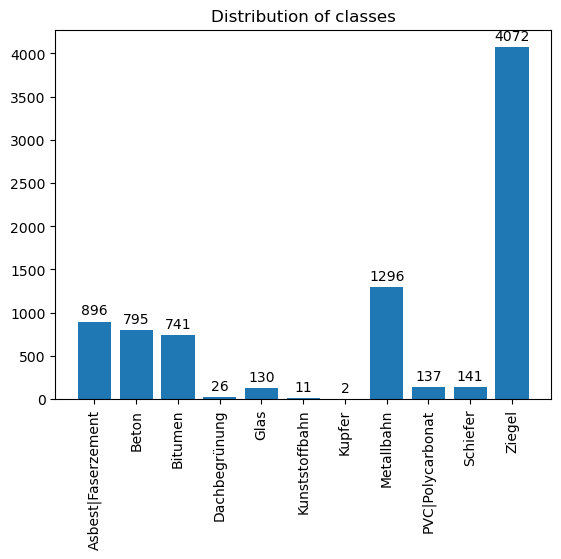

                    count
Klasse                   
Asbest|Faserzement    896
Beton                 795
Bitumen               741
Dachbegrünung          26
Glas                  130
Kunststoffbahn         11
Kupfer                  2
Metallbahn           1296
PVC|Polycarbonat      137
Schiefer              141
Ziegel               4072


In [22]:
class_count = df.loc[:,['WKT','mat_qgis']].groupby(by='mat_qgis', dropna=False).count()
class_count.rename({'WKT': 'count'}, axis=1, inplace=True)
class_count.index.name= 'Klasse'

print('Number of data points:' ,class_count.iloc[:,0].sum())


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


classes = np.array(class_count.index.array)
counts = np.array(class_count['count'].array)
rects = plt.bar(classes, counts)
plt.title('Distribution of classes')
plt.xticks(rotation = 90)
ax = plt.gca()
autolabel(rects)
plt.show()


print(class_count)

### Distribution of Classes English

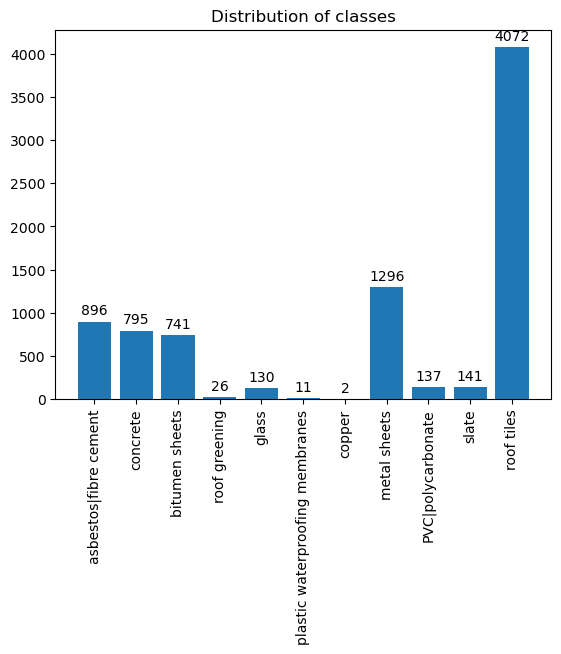

                    count
Klasse                   
Asbest|Faserzement    896
Beton                 795
Bitumen               741
Dachbegrünung          26
Glas                  130
Kunststoffbahn         11
Kupfer                  2
Metallbahn           1296
PVC|Polycarbonat      137
Schiefer              141
Ziegel               4072


In [10]:
class_count = df.loc[:,['WKT','mat_qgis']].groupby(by='mat_qgis', dropna=False).count()
class_count.rename({'WKT': 'count'}, axis=1, inplace=True)
class_count.index.name= 'Klasse'


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


classes = [ 'asbestos|fibre cement',  'concrete', 'bitumen sheets', 'roof greening',  'glass',
                    'plastic waterproofing membranes', 'copper', 'metal sheets', 'PVC|polycarbonate', 'slate', 'roof tiles']
counts = np.array(class_count['count'].array)
rects = plt.bar(classes, counts)
plt.title('Distribution of classes')
plt.xticks(rotation = 90)
ax = plt.gca()
autolabel(rects)
plt.show()


print(class_count)

# Preprocessing

## Functions for Preprocessing
These functions are used in our preprocessing process

In [9]:
# read tfw file and return coordinates of upper left pixel and the pixel size
def read_tfw(path):
    f = open(path)
    tfw = f.read()
    f.close()
    tfw = tfw.split('\n') #split lines
    tfw.remove('') # remove empty line
    tfw = list(map(lambda s : float(s), tfw)) # cast strings to float

    x_upper_left, y_upper_left = tfw[4], tfw[5]
    x_pixel_size, y_pixel_size = tfw[0], -tfw[3]
    return x_upper_left, y_upper_left, x_pixel_size, y_pixel_size


# convert coordinates (of polygons) to pixel in orthophoto
def convert_coordinate(x,y, x_upper_left, y_upper_left, x_pixel_size, y_pixel_size):
    x_image = int((x - x_upper_left) / x_pixel_size)
    y_image = int((y - y_upper_left) / y_pixel_size)
    return (x_image, y_image)

# parse polygon to list of coordinates
def parse_polygon(s):
    coordinates = s.split(',')
    polygon = []
    for coordinate in coordinates:
        (u,v) = coordinate.split(' ')
        polygon.append((float(u), float(v)))
    return polygon

# cut image from orthophoto based on minimal and maximal x and y coordinates. Create a mask that captures roof in cut image.
# White out non mask pixels
def crop_image(image, polygon):
    xs = [x for (x,y) in polygon]
    ys = [y for (x,y) in polygon]
    x_min = min(xs)
    x_max = max(xs)
    y_min = min(ys)
    y_max = max(ys)
    cropped = image[y_min:y_max+1,x_min:x_max+1].copy()       
    cropped_polygon = [ (x - x_min, y - y_min) for (x,y) in polygon]
    mask = sk.draw.polygon2mask(cropped.shape[0:2], [(y,x) for (x,y) in cropped_polygon])    
    
    for y in range(0, cropped.shape[0]):
        for x in range(0, cropped.shape[1]):
            if (not mask[y,x]):
                cropped[y,x,0] = 1
                cropped[y,x,1] = 1
                cropped[y,x,2] = 1 
    
    return cropped, mask






## Functions for Splitting the Data
We aim to split our data into train, test and validation sets. To ensure the same distribution of classes for each set, we perform this split for each roof category separately. We use either a random or a region-based method to split the data.

In [10]:
# Splits the data into train and test and validation sets at random
def split_data_random(main_dir, training_dir, validation_dir, test_dir, seed=12345):
    """
    Args:
    main_dir (string):  path containing the images
    training_dir (string):  path to be used for training
    validation_dir (string):  path to be used for validation
    test_dir (string):  path to be used for testing
    """
    files = []
    for file in os.listdir(main_dir):
        if  os.path.getsize(os.path.join(main_dir, file)): # check if the file's size isn't 0
            files.append(file) # appends file name to a list

    random.seed(seed)
    shuffled_files = random.sample(files,  len(files)) # shuffles the data
    split = int(0.8 * len(shuffled_files)) #the training split casted into int for numeric rounding
    split2= int(0.9 * len(shuffled_files))

    train = shuffled_files[:split] #training split
    validation = shuffled_files[split:split2] # validation split
    test = shuffled_files[split2:]
    for element in train:
        copyfile(os.path.join(main_dir,  element), os.path.join(training_dir, element)) # copy files into training directory

    for element in validation:
        copyfile(os.path.join(main_dir,  element), os.path.join(validation_dir, element))# copy files into validation directory

    for element in test:
        copyfile(os.path.join(main_dir,  element), os.path.join(test_dir, element))# copy files into validation directory

import re

# Splits the data into train and test and validation sets at based of name of region (ezg feature in main data source)
def split_data_region(main_dir, training_dir, validation_dir, test_dir, region_for_test):

    files = []
    test = []

    # all data from selected region goes to test data
    for file in os.listdir(main_dir):
        if ( region_for_test in file ):
            test.append(file)
        else:
            files.append(file)
    
    # all other data is split into train and validation part
    random.seed(5345435)
    shuffled_files = random.sample(files,  len(files)) # shuffles the data
    split = int(0.8 * len(shuffled_files)) #the training split casted into int for numeric rounding

    train = shuffled_files[:split] #training split
    validation = shuffled_files[split:] # validation split

    for element in train:
        copyfile(os.path.join(main_dir,  element), os.path.join(training_dir, element)) # copy files into training directory

    for element in validation:
        copyfile(os.path.join(main_dir,  element), os.path.join(validation_dir, element))# copy files into validation directory

    for element in test:
        copyfile(os.path.join(main_dir,  element), os.path.join(test_dir, element))# copy files into validation directory




## Create Directories for Classes
We assign each class a separate directory and store all the images belonging to that class in it. Our directory structure is as follows:
- all_data
    - class 1
    - class 2
    - ...
- train
    - class 1
    - class 2
    - ...
- validation
    - class 1
    - class 2
    - ...
- test
    - class 1
    - class 2
    - ...

The all_data directory contains the entire dataset, while the train, validation and test directories contain the data split according to its usage.

In [11]:
df = pd.read_csv(os.path.join(SOURCE_DIR, 'umrisse_clean.csv'), index_col=0) # read cleaned DataFrame
regions = pd.unique(df['ezg']) # all regions
classes = pd.unique(df['mat_qgis']) # all classes
grouped_by_regions = df.groupby(by='ezg').groups # group images (index of images) by region (ezg)
df['area'] = 0  #new feature to store surface area of images

In [12]:
try:
    if os.path.isdir(DESTINATION_DIR):
        print(DESTINATION_DIR, 'exists and will be deleted...')
        rmtree(DESTINATION_DIR)
    os.mkdir(DESTINATION_DIR)
    for usage in ['train', 'validation', 'test', 'all_data']:
        os.mkdir(os.path.join(DESTINATION_DIR, usage))
        for material in classes:
            os.mkdir(os.path.join(DESTINATION_DIR, usage, str(material)))
except OSError as error:
    print(error)  

/home/mniederer/workspace/data/new_data exists and will be deleted...


## Cut Roofs from Orthophoto
The following code implements the main preprocessing process: For each region, we load the Orthophoto and apply CLAHE. Then we extract all the roofs from that region. For each roof, we mask out all the pixels that are not part of the roof and compute the surface area of the roof using its mask. Finally, we save the image of each roof and store the surface area in our DataFrame.

In [17]:
from skimage import exposure
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value

# calculate area of polygon by its mask and pixel_size in tfw
def calculate_area(mask, x_pixel_size, y_pixel_size):
    one_counter = 0
    for pixel in np.nditer(mask):
        if pixel == 1:
            one_counter += 1
    

    return round(-one_counter * x_pixel_size * y_pixel_size,2)

# CLAHE
@adapt_rgb(hsv_value)
def adaptive_hist_hsv(image):
    return exposure.equalize_adapthist(image, clip_limit=0.03)


# here begins the main part
for region in grouped_by_regions:       # for each region
    print('Processing ',region, '...')
    orthophoto = sk.io.imread(os.path.join(SOURCE_DIR, region +'.tiff')) # read orthophoto from file
    orthophoto = orthophoto.astype('float32') # convert int to float
    orthophoto /= 255  # int pixels: [0, 1, ... , 255]  to float pixels [0,1[
    x_upper_left, y_upper_left, x_pixel_size, y_pixel_size = read_tfw(os.path.join(SOURCE_DIR, region +'.tfw'))
    
    for index in grouped_by_regions[region]: # for each roof in that region
        material = df.iloc[index].mat_qgis  # roof material class of that roof
        id = df.iloc[index].id
        poly_string_splitted = re.split("[\(\)]+", df.iloc[index].WKT) # prepare polygon string
        polygon = parse_polygon(poly_string_splitted[1]) # parse polygon string
        polygon_image = [convert_coordinate(x,y, x_upper_left, y_upper_left, x_pixel_size, y_pixel_size) for (x,y) in polygon] # convert coordinates to pixel in image
        cropped, mask = crop_image(orthophoto, polygon_image) # cut image
        try:
            df.iloc[index,6] = calculate_area(mask, x_pixel_size, y_pixel_size)  # calculate and save new feature: 'area'
        except ValueError as error:
            print('Error with id:{}'.format(index),error)
        try:
            cropped *= 255 # convert back to int for saving image
            int_final = cropped.astype('uint8')
            sk.io.imsave(os.path.join(DESTINATION_DIR, 'all_data' ,material, region+ '_' +str(id)+'.jpg'), int_final, check_contrast=False) # save image
        except IndexError as error:
            print(error)        
        except ValueError as error:
            print(error)

Processing  Industriegebiet_Fordwerke ...


Processing  Industriegebiet_Heiligenwald ...
Processing  Industriegebiet_Theley ...
Processing  Kerngebiet_Saarlouis ...
Processing  Kerngebiet_Schiffweiler ...
Processing  Kerngebiet_Tholey ...
Processing  Mischgebiet_Fraulautern ...
Processing  Mischgebiet_Landsweiler-Reden ...
Processing  Mischgebiet_Tholey ...
Processing  Wohngebiet_Bergweiler ...
Processing  Wohngebiet_Neuforweiler ...
Processing  Wohngebiet_Stennweiler ...
Processing  Wohngebiet_Tholey ...


## Save Dataframe with New Features: Area and Area Type

In [18]:
df.loc[df['area'].isna(), 'area'] = 1  #very small values (close to 0) make problems. So just set them to 1   
df.to_csv(os.path.join(SOURCE_DIR, 'umrisse_with_all_data.csv'), index=False)

## Split Data
Split data into train, validation and test sets at random. Do this for each class individually to maintain the distribution of classes.

In [20]:
for material in classes:
   split_data_random(os.path.join(DESTINATION_DIR, 'all_data', str(material)), os.path.join(DESTINATION_DIR, 'train', str(material)), os.path.join(DESTINATION_DIR, 'validation', str(material)), os.path.join(DESTINATION_DIR, 'test', str(material)))

'''
for material in classes:
    split_data_region(  os.path.join(DESTINATION_DIR, 'all_data', str(material)),
                        os.path.join(DESTINATION_DIR, 'train', str(material)),
                        os.path.join(DESTINATION_DIR, 'validation', str(material)),
                        os.path.join(DESTINATION_DIR, 'test', str(material)),
                        'Industriegebiet_Fordwerke')
                        '''

"\nfor material in classes:\n    split_data_region(  os.path.join(DESTINATION_DIR, 'all_data', str(material)),\n                        os.path.join(DESTINATION_DIR, 'train', str(material)),\n                        os.path.join(DESTINATION_DIR, 'validation', str(material)),\n                        os.path.join(DESTINATION_DIR, 'test', str(material)),\n                        'Industriegebiet_Fordwerke')\n                        "